In [0]:
from google.colab import files
src = list(files.upload().values())[0]
open('corrfx.py','wb').write(src)
import corrfx

Saving corrfx.py to corrfx.py


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
main='https://raw.githubusercontent.com/huddyyeo/LSE_practitioners_challenge/master/Data/'
yieldd='UK_gilt_yield_data.csv'
yield_format='%Y-%m-%d'
ftse='FTSE100_closing_data.csv'
ftse_format='%d/%m/%Y'
inflation='UK_inflation_data.csv'
inflation_format='%Y'
gdp='UK_GDP_data.csv'
gdp_format='%Y'
risk_free_rate='UK_risk_free_rate_data.csv'
risk_free_rate_format=''

url_list=[ftse,yieldd,inflation,gdp,risk_free_rate]
data_type=[1,1,1,1,1]
date_format=[ftse_format,yield_format,inflation_format,gdp_format,risk_free_rate_format]
names=['FTSE','Yield','Inflation','GDP','RF Rate']

#creation of our data environment
data_env=corrfx.data_environment(main,url_list,data_type,date_format)

In [0]:
num=len(data_env.data)
min_length=4
max_length=61
index=np.array(list(range(min_length,max_length)))

In [0]:
data=data_env.resample_all(interpolate_method='linear')
data=data.dropna()
data=data.iloc[:-10]

In [0]:
data

,Log-return_x,Log-return_y,Log-return_x,Log-return_y,Log-return
Date,,,,,
1998-04-30,-0.006620,-0.014805,-0.152081,0.033737,0.055940
1998-05-31,0.000536,0.009104,-0.176808,0.033744,-0.015525
1998-06-30,-0.102557,-0.043981,-0.200738,0.033751,-0.090821
1998-07-31,-0.038144,-0.077264,-0.225466,0.033759,-0.098759
1998-08-31,0.067794,-0.029115,-0.250194,0.033766,-0.007070
...,...,...,...,...,...
2018-09-30,-0.022009,-0.058406,-0.077020,0.074575,-0.117847
2018-10-31,-0.036275,-0.101130,-0.051346,0.081487,-0.127652
2018-11-30,0.032766,0.003630,-0.026501,0.088176,0.038709


In [0]:
#getting the dataset
df=pd.merge(data_env.data[3],data_env.data[2],on='Date',how='outer')
df=df.dropna()
df.head()

,Date,Log-return_x,Log-return_y
41,1989-01-01,0.007311,0.338975
42,1990-01-01,-0.011093,-0.064539
43,1991-01-01,0.004003,-0.488847
44,1992-01-01,0.024593,-0.570545
45,1993-01-01,0.037739,-0.167054


In [0]:
def mse(x,y):
  return np.mean(np.square(x-y))
def mae(x,y):
  return np.mean(np.abs(x-y))
def L1(x):
  return np.sum(np.abs(x))
def L2(x):
  return np.sqrt(np.sum(np.square(x)))
def Lmax(x):
  return np.maximum(np.abs(x))

def get_error_array(data,forecast,i,j,min_length=4,max_length=61,method=mse):
  error_array=[]
  for length in range(min_length,max_length):
    x=data.iloc[:,i].values
    y=data.iloc[:,j].values
    rolling_corr=corrfx.roll_corr(x,y,length)
    rolling_corr=rolling_corr[-12:]
    error=method(forecast,rolling_corr)
    error_array.append(error)
  return error_array
   

In [0]:
forecast=pd.read_csv('https://raw.githubusercontent.com/huddyyeo/LSE_practitioners_challenge/master/Data/forecasts_t.csv')
forecast

,Yield:FTSE,Inflation:FTSE,GDP:FTSE,RF_rate:FTSE,Inflation:Yield,GDP:Yield,RF_rate:Yield,GDP:Inflation,RF_rate:Inflation,RF_rate:GDP
0,-0.338067,0.270643,0.265893,-0.299735,-0.334483,-0.280264,0.911863,0.499115,-0.346392,-0.267088
1,-0.117587,0.313613,0.314599,-0.260095,-0.130034,-0.061234,0.796408,0.493700,-0.328640,-0.248293
2,-0.037548,-0.073958,-0.094275,-0.102921,-0.098744,-0.027857,0.821234,0.495064,-0.241204,-0.152479
3,-0.002982,-0.129034,-0.150670,-0.085879,-0.064953,0.008146,0.828405,0.495728,-0.098329,-0.000752
4,0.057549,-0.033877,-0.048119,-0.008422,0.064423,0.142550,0.852324,0.496898,0.021184,0.123878
5,-0.026098,-0.057019,-0.077214,-0.088400,0.067060,0.104753,0.843189,0.537573,-0.026301,0.048189
6,-0.091570,0.188252,0.173225,-0.083500,-0.005196,0.031073,0.846699,0.544106,-0.052170,0.020640
7,0.031746,0.114346,0.111301,0.038074,-0.203073,-0.148183,0.891895,0.508208,-0.215584,-0.136400
8,-0.115514,0.329291,0.340717,-0.013169,-0.237418,-0.181345,0.875987,0.512819,-0.187110,-0.102210
9,0.075436,0.337600,0.348302,0.192784,0.029222,0.098224,0.881130,0.516750,0.156001,0.242944


In [0]:
#writing out the order of the columns
forecast_names=[(1,0),(2,0),(3,0),(4,0),(2,1),(3,1),(4,1),(3,2),(4,2),(4,3)]
forecast_names=np.array(forecast_names,dtype='object')

In [0]:
#function that finds the position of the input vector in the list
def arg_where(x,y):
  for i in range(len(x)):
    if np.array_equal(x[i],y):
      return i
  return -1

#calculates the error, returns in a matrix form
def calculate_error(forecast,forecast_names,data,min_length=4,max_length=61):
  mse_errors=np.ndarray((num,num),dtype=object)
  mae_errors=np.ndarray((num,num),dtype=object)
  for i in range(num):
    for j in range(num):
      mse_errors[i,j]=-1
      mae_errors[i,j]=-1
      pos=arg_where(forecast_names,[i,j])
      if pos==-1:
        continue
      forecast_slice=forecast.iloc[:,pos].values
      #print(i,j)
      mse_errors[i,j]=get_error_array(data,forecast_slice,i,j,min_length=min_length,max_length=max_length)
      mae_errors[i,j]=get_error_array(data,forecast_slice,i,j,min_length=min_length,max_length=max_length,method=mae)
  return mse_errors,mae_errors

#plots the error 
def plot_matrix_errors(mse_error,mae_error):
  plt.figure(figsize=[18,18])
  plt.title('Errors')
  for i in range(num):
    for j in range(num):
      if mse_error[i,j]==-1:
        continue
      plt.subplot(5,5,5*i+j+1)
      index=np.array(list(range(min_length,max_length)))
      plt.plot(index,mse_error[i,j],label='MSE')
      plt.plot(index,mae_error[i,j],label='MAE')
      name=names[i]+','+names[j]
      plt.title(name)
  plt.legend()

#plot forecast_vs real
def plot_forecast(forecast,forecast_names,data,length):
  plt.figure(figsize=[18,18])
  plt.title('Forecast vs Actual')
  for i in range(num):
    for j in range(num):
      pos=arg_where(forecast_names,[i,j])
      if pos==-1:
        continue
      forecast_slice=forecast.iloc[:,pos].values
      fore=corrfx.roll_corr(data.iloc[:,i].values,data.iloc[:,j].values,length)
      fore=fore[-12:]
      plt.subplot(5,5,5*i+j+1)
      plt.plot(fore,label= 'Rolling Corr')
      plt.plot(forecast_slice,label='DCC')
      name=names[i]+','+names[j]
      plt.title(name)
  plt.legend()

def plot_norm_errors(mae_error,mse_error,norm=None,plot=True):
  matrix_mae=np.expand_dims(np.array(mae_error[1,0]),axis=1)
  matrix_mse=np.expand_dims(np.array(mse_error[1,0]),axis=1)
  for i in range(num):
    for j in range(num):
      if mse_error[i,j]==-1:
        continue
      if (i==1 and j==0):
        continue
      matrix_mse=np.concatenate((matrix_mse,np.expand_dims(np.array(mse_error[i,j]),axis=1)),axis=1)
      matrix_mae=np.concatenate((matrix_mae,np.expand_dims(np.array(mae_error[i,j]),axis=1)),axis=1)
  if plot==True:
    plt.figure(figsize=[10,10])
    normed_error_mse=np.linalg.norm(matrix_mse,axis=1,ord=norm)
    normed_error_mae=np.linalg.norm(matrix_mae,axis=1,ord=norm)
    plt.plot(index,normed_error_mae,label='MAE')
    plt.plot(index,normed_error_mse,label='MSE')


    min_pos_mae=np.argmin(normed_error_mae[~np.isnan(normed_error_mae)])+ len(normed_error_mae[np.isnan(normed_error_mae)])
    min_pos_mse=np.argmin(normed_error_mse[~np.isnan(normed_error_mse)])+ len(normed_error_mse[np.isnan(normed_error_mse)])
    
    plt.scatter(index[min_pos_mae],normed_error_mae[min_pos_mae])
    plt.scatter(index[min_pos_mse],normed_error_mse[min_pos_mse])

    plt.annotate('Minimum at '+str(index[min_pos_mae]),(index[min_pos_mae],normed_error_mae[min_pos_mae]),xytext=(-40, -15), textcoords='offset points',)
    plt.annotate('Minimum at '+str(index[min_pos_mse]),(index[min_pos_mse],normed_error_mse[min_pos_mse]),xytext=(-40, -15), textcoords='offset points',)
    
    plt.xlabel('Rolling Correlation Length in Months')
    plt.ylabel('Normed Error')
    plt.legend()

    return
  return np.linalg.norm(matrix_mse,axis=1,ord=norm),np.linalg.norm(matrix_mae,axis=1,ord=norm)


#returns dataframe of the top 10 smallest error rolling window correlation lengths
def top_10_lengths(error,min_length=4,max_length=61):
  top10=pd.DataFrame()
  index=np.array(list(range(min_length,max_length)))
  for i in range(num):
    for j in range(num):
      if error[i,j]==-1:
        continue
      sorter=np.argsort(error[i,j])
      top_index=index[sorter][:10]
      name=names[i]+','+names[j]
      top10[name]=top_index
  return top10 

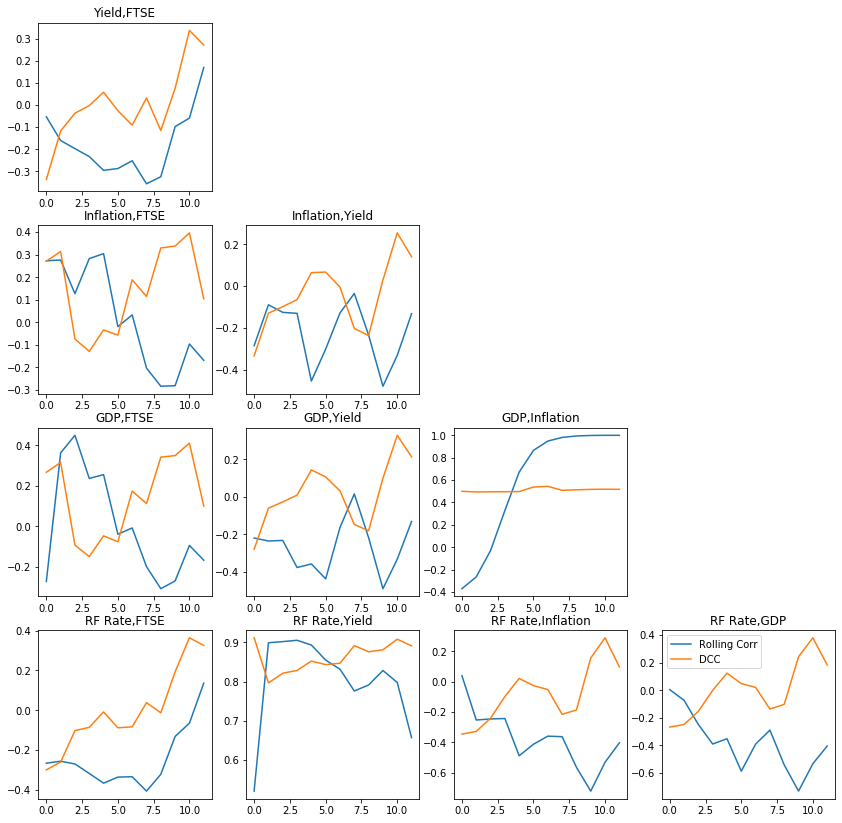

In [0]:
plot_forecast(forecast,forecast_names,data,length=12)
plt.savefig('correlations.png',dpi=300)
files.download('correlations.png')

In [0]:
mse_error,mae_error=calculate_error(forecast,forecast_names,data,min_length=min_length,max_length=max_length)

In [0]:
top_10_lengths(mse_error,min_length=min_length,max_length=max_length)

,"Yield,FTSE","Inflation,FTSE","Inflation,Yield","GDP,FTSE","GDP,Yield","GDP,Inflation","RF Rate,FTSE","RF Rate,Yield","RF Rate,Inflation","RF Rate,GDP"
0,22,31,59,60,42,22,17,45,28,43
1,23,32,60,58,43,21,16,44,29,42
2,21,30,55,55,54,23,18,46,60,44
3,20,33,56,57,41,20,20,43,59,41
4,17,34,58,59,55,24,19,55,58,45
5,19,35,57,56,39,19,21,42,57,46
6,24,36,54,54,40,25,15,47,56,40
7,18,29,48,53,44,4,22,54,54,37
8,56,37,49,51,56,5,53,56,55,38
9,54,39,53,50,51,26,52,48,49,47


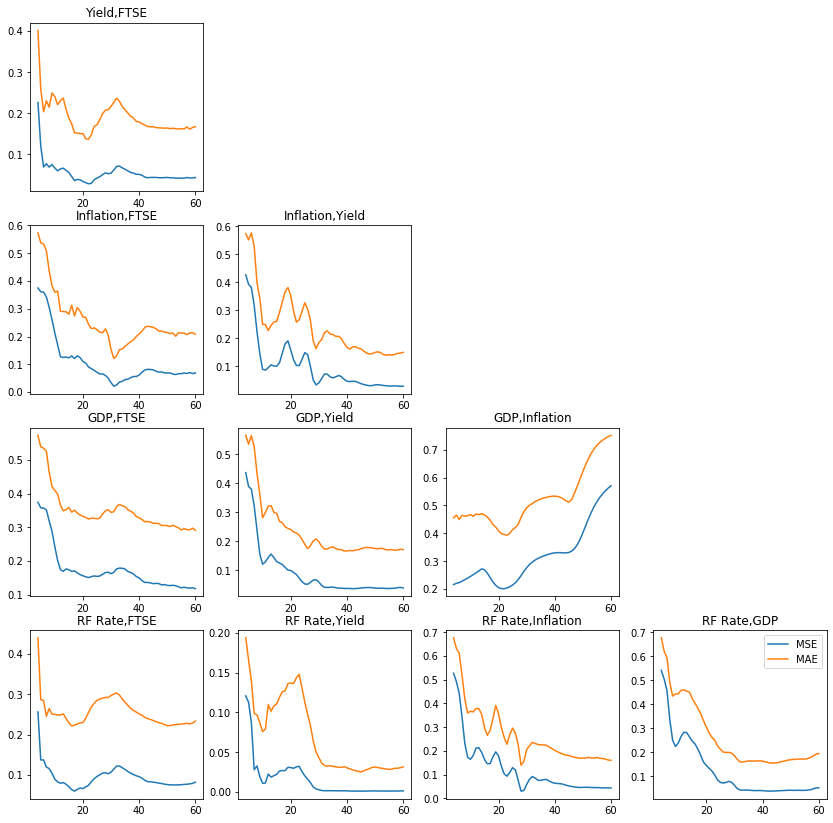

In [0]:
plot_matrix_errors(mse_error,mae_error)
plt.savefig('errors.png',dpi=300)
files.download('errors.png')

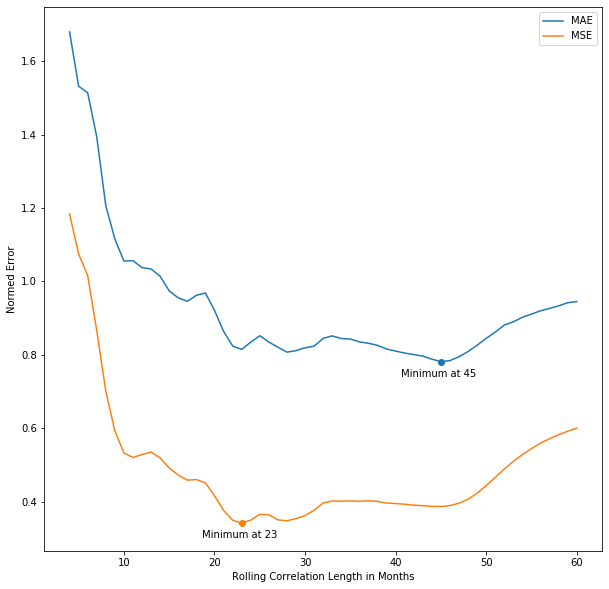

In [0]:
plot_norm_errors(mae_error,mse_error)
plt.savefig('normed_error.png',dpi=300)
files.download('normed_error.png')

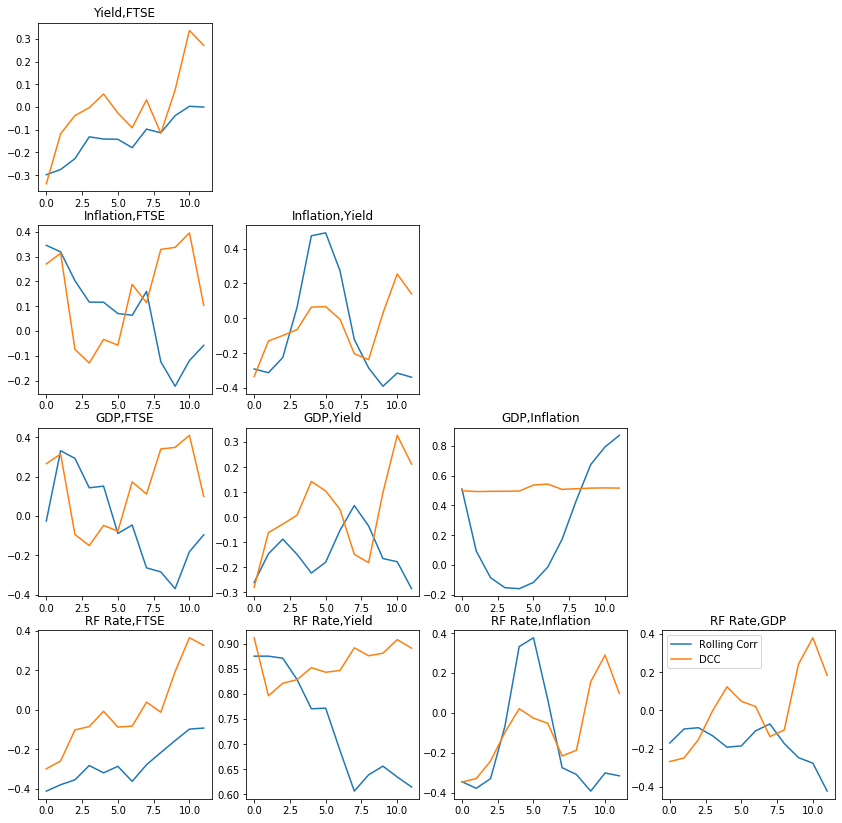

In [0]:
plot_forecast(forecast,forecast_names,data,length=23)
plt.savefig('min_error_forecast.png',dpi=300)
files.download('min_error_forecast.png')